In [22]:
import os, sys, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from sklearn.linear_model import SGDClassifier, LogisticRegression

In [23]:
pd.options.display.max_columns = None

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
pd.set_option('display.max_rows', 1000)

In [26]:
# X_train = pd.read_csv("/content/drive/My Drive/Healthcare Competition/X_train.csv")

In [27]:
# # TARGET
# y_train = X_train['transportation_issues'].copy()
# y_train = y_train.astype("int")

In [28]:
%%time
X_train = pd.read_csv("/content/drive/My Drive/Healthcare Competition/parsed_training.csv")
# X_test = pd.read_csv("/content/drive/My Drive/Healthcare Competition/原始数据/2020_Competition_Holdout .csv")

# PRINT STATUS
# print('Train shape',X_train.shape,'test shape',X_test.shape)

<string>:2: DtypeWarning: Columns (194) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 6.84 s, sys: 341 ms, total: 7.18 s
Wall time: 7.46 s


In [30]:
# Delete redunant variables using Lyndon's dataset
xl = pd.ExcelFile("/content/drive/My Drive/Healthcare Competition/9.25final.xlsx")
df_Lyndon_firstRound = xl.parse("Sheet1")
df_Lyndon_firstRound.head(2)
# Generate a dataframe with only Lyndon's filtered variables left
df_Lyndon_firstRound_filtered = df_Lyndon_firstRound.loc[df_Lyndon_firstRound['Target_col'] == 1]
lyndon_list = df_Lyndon_firstRound_filtered["index"].tolist()
X_train = X_train.loc[:,X_train.columns.isin(lyndon_list)]
# X_test = X_test.loc[:,X_test.columns.isin(lyndon_list)]

In [31]:
# Dealing with missing value
ls_columns = X_train.columns.tolist()
# Columns with missing value
columns_with_missing = []
for column in ls_columns:
    if X_train[column].isnull().sum()>0: 
        columns_with_missing.append({"column":column, "missing":X_train[column].isnull().sum()}) 
df_missing_distribution = pd.DataFrame.from_dict(columns_with_missing) 
from sklearn.impute import SimpleImputer
# rank 1 blood fat screen or control
# rank 2 data from cons about demos
# rank 3 cms data insurance factor data.
imputer_frequent = SimpleImputer(strategy="most_frequent")
for column in df_missing_distribution["column"]:
    try:
        if X_train[column].nunique()>=30:
            X_train[column].fillna(X_train[column].mean(),inplace=True)
        else:
            X_train[column].fillna(X_train[column].value_counts().index[0],inplace=True)
    except:
        print(column)

In [35]:
# TARGET
y_train = X_train['transportation_issues'].copy()
y_train = y_train.astype("int")

In [36]:
# from sklearn.preprocessing import MinMaxScaler
# # Scale the data 
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [37]:
# TRAIN 75% PREDICT 25% - Evaluation set
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

y_train = y_train.astype("int")
X_train = pd.get_dummies(X_train)

In [38]:
# X_train.to_csv('X_train.csv')
X_train = X_train.drop(columns=['transportation_issues'])

In [39]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import PolynomialFeaturesf

In [40]:
print("XGBoost version:", xgb.__version__)
# [280]	validation_0-auc:0.73652
clf = xgb.XGBClassifier( 
    n_estimators=5000,
    max_depth=6, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    missing=-1, 
    eval_metric='auc',
    # USE CPU
    #nthread=4,
    #tree_method='hist' 
    # USE GPU
    tree_method='gpu_hist' 
)
cols = list(X_train.columns)
h = clf.fit(X_train.loc[idxT], y_train[idxT], 
    eval_set=[(X_train.loc[idxV],y_train[idxV])],
    verbose=50, early_stopping_rounds=500)


XGBoost version: 0.90
[0]	validation_0-auc:0.697076
Will train until validation_0-auc hasn't improved in 500 rounds.
[50]	validation_0-auc:0.729382
[100]	validation_0-auc:0.732734
[150]	validation_0-auc:0.735481
[200]	validation_0-auc:0.738667
[250]	validation_0-auc:0.741098
[300]	validation_0-auc:0.741938
[350]	validation_0-auc:0.742859
[400]	validation_0-auc:0.743186
[450]	validation_0-auc:0.743203
[500]	validation_0-auc:0.743389
[550]	validation_0-auc:0.743377
[600]	validation_0-auc:0.743432
[650]	validation_0-auc:0.743357
[700]	validation_0-auc:0.743238
[750]	validation_0-auc:0.742523
[800]	validation_0-auc:0.74221
[850]	validation_0-auc:0.741713
[900]	validation_0-auc:0.741523
[950]	validation_0-auc:0.741355
[1000]	validation_0-auc:0.741111
[1050]	validation_0-auc:0.74047
[1100]	validation_0-auc:0.740333
Stopping. Best iteration:
[621]	validation_0-auc:0.743542



In [43]:
pred_test = h.predict(X_train.loc[idxV])
pred=h.predict_proba(X_train.loc[idxV])[:,1]

In [102]:
y_probs = y_probs[:, 1]

ROC_AUC Score:
0.7435424966906331


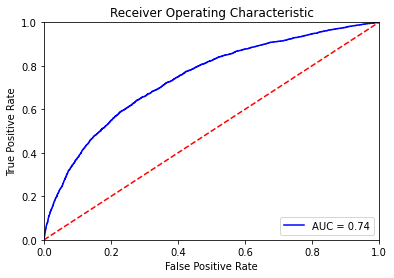

In [45]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

print("ROC_AUC Score:")
print(roc_auc_score(y_train[idxV], pred))

#ROC Plot
fpr, tpr, threshold = metrics.roc_curve(y_train[idxV], pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

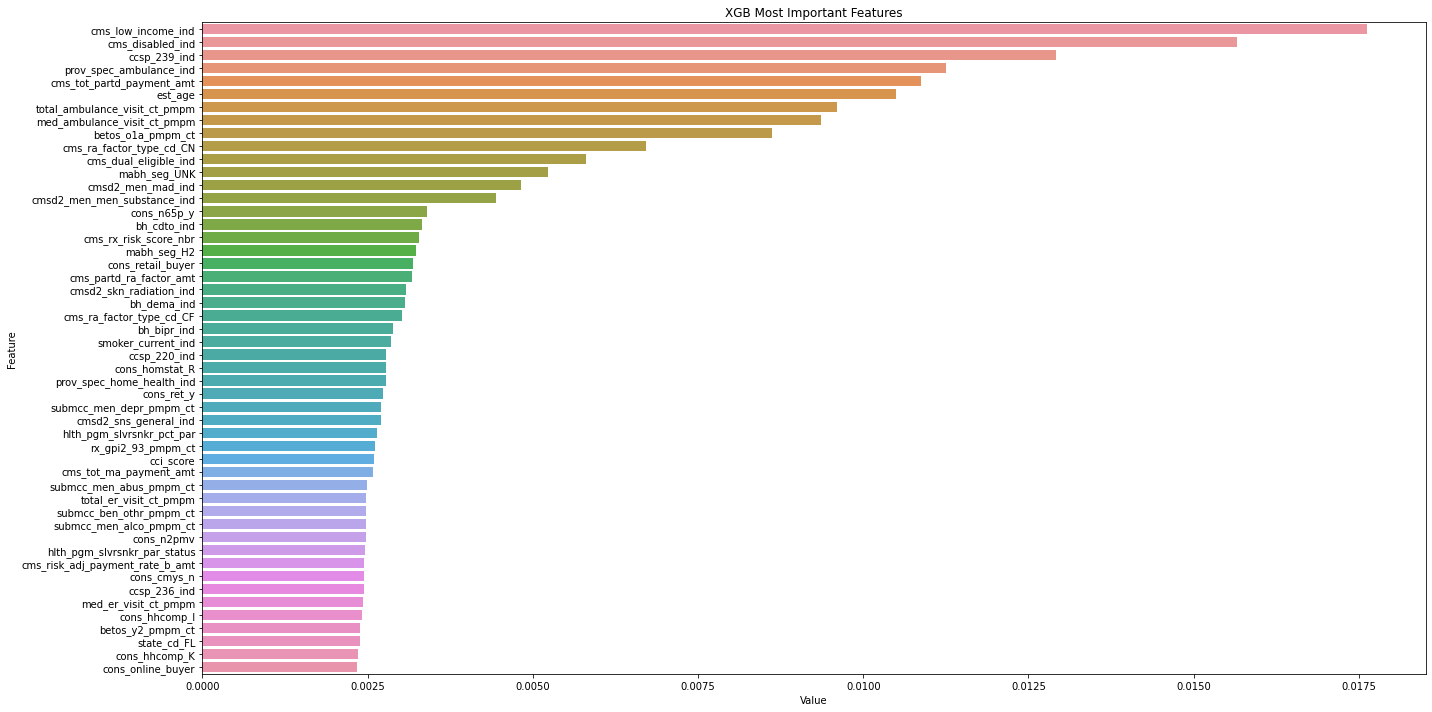

In [46]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
params={'booster':'gbtree', # defalt
        'objective': 'binary:logistic',
        'eval_metric':'auc',
        'eta':0.1, # Learning rate in GBM
        'min_child_weight':1, # default
        'max_depth': 3, #  需要使用CV函数来进行调优。 典型值：3-10
        'gamma':0.1, #Gamma指定了节点分裂所需的最小损失函数下降值。 这个参数的值越大，算法越保守。这个参数的值和损失函数息息相关，所以是需要调整的。
        'lambda':10, #权重的L1正则化项。(和Lasso regression类似)。 可以应用在很高维度的情况下，使得算法的速度更快。
        'subsample':0.7, # 控制对于每棵树，随机采样的比例。 减小这个参数的值，算法会更加保守，避免过拟合。但是，如果这个值设置得过小，它可能会导致欠拟合。 典型值：0.5-1
        'colsample_bytree':0.7, #和GBM里面的max_features参数类似。用来控制每棵随机采样的列数的占比(每一列是一个特征)。 典型值：0.5-1
        'colsample_bylevel':0.7, # 先不考虑
        'tree_method':'exact',
        'seed':0,
        'nthread':12
        }